<a href="https://colab.research.google.com/github/ccoyso/Tapia/blob/main/c_digo_para_detecci_n_de_c_ncer_pulmonar_con_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importación de Bibliotecas

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2

# Explicación:
**os:** Se utiliza para interactuar con el sistema operativo, como acceder a directorios y archivos.

**numpy (np):** Biblioteca fundamental para operaciones numéricas eficientes en Python.

**matplotlib.pyplot (plt):** Herramienta para visualización de datos (gráficos, imágenes).

**PIL.Image:** Permite abrir, manipular y guardar imágenes en diferentes formatos.

**torch:** Framework principal de PyTorch, usado para redes neuronales y aprendizaje profundo.

**torchvision:** Extensión de PyTorch para visión por computadora (datasets, transformaciones, modelos preentrenados).

**nn:** Módulo de PyTorch para definir arquitecturas de redes neuronales.

optim: Contiene algoritmos de optimización como SGD, Adam, etc.

**Dataset, DataLoader:** Clases para cargar y gestionar conjuntos de datos en lotes (batches).

**random_split:** Divide un dataset en subconjuntos (entrenamiento/validación).

**sklearn.metrics:** Proporciona métricas de evaluación como matriz de confusión y reporte de clasificación.

**seaborn:** Mejora la visualización de datos estadísticos, útil para gráficos de métricas.

# 2. Descarga del Dataset desde Kaggle

In [ ]:
!pip install opendatasets --quiet

import opendatasets as od


In [ ]:
dataset_url = "https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images"

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mactapia
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


100%|██████████| 1.76G/1.76G [00:12<00:00, 155MB/s]


# Explicación:
**opendatasets:** Librería que facilita la descarga de datasets desde plataformas como Kaggle.

**dataset_url:** Enlace al dataset público de imágenes histopatológicas de cáncer de pulmón y colon.

**od.download():** Descarga el dataset en el entorno de trabajo (requiere credenciales de Kaggle).

# 3. Configuración de Hiperparámetros

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3

# Explicación:
**IMG_SIZE = 224:**

Las imágenes se redimensionarán a 224x224 píxeles, tamaño estándar para modelos como ResNet50.

**BATCH_SIZE = 32:**

Número de imágenes procesadas en cada iteración durante el entrenamiento.

**NUM_CLASSES = 3:**

**Clases del dataset:**

**lung_aca:** Adenocarcinoma de pulmón.

**lung_n:** Tejido pulmonar normal.

**lung_scc:** Carcinoma de células escamosas de pulmón.


# 4. Configuración de Directorios y Categorías

In [ ]:
DATADIR = "/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"

CATEGORIES = ['lung_aca', 'lung_n', 'lung_scc']

# Explicación:
**DATADIR:**

Ruta donde se almacenan las imágenes del dataset.

**CATEGORIES:**

Subcarpetas que representan las 3 clases de diagnóstico:

**lung_aca**: Imágenes de adenocarcinoma.

**lung_n**: Imágenes de tejido sano.

**lung_scc**: Imágenes de carcinoma de células escamosas.

# 5. Visualización de Imágenes del Dataset

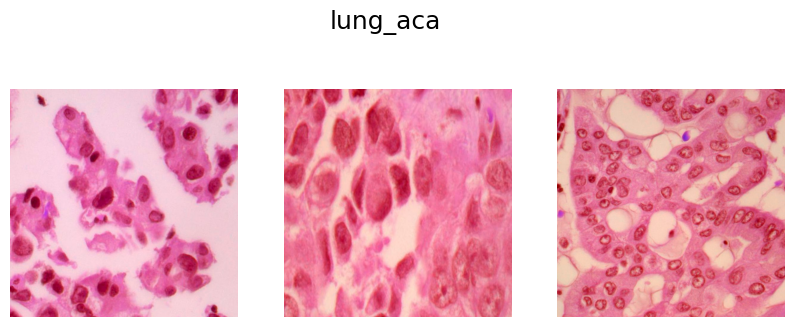

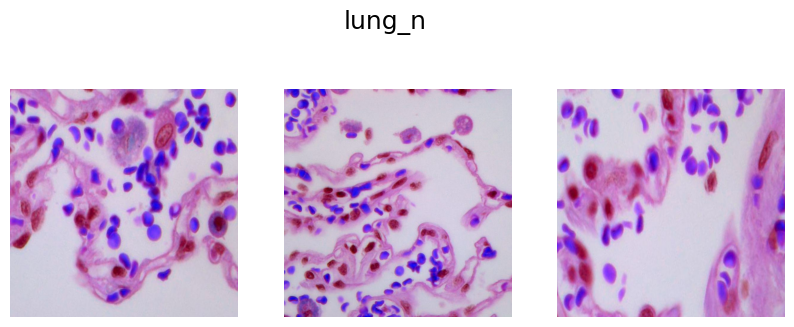

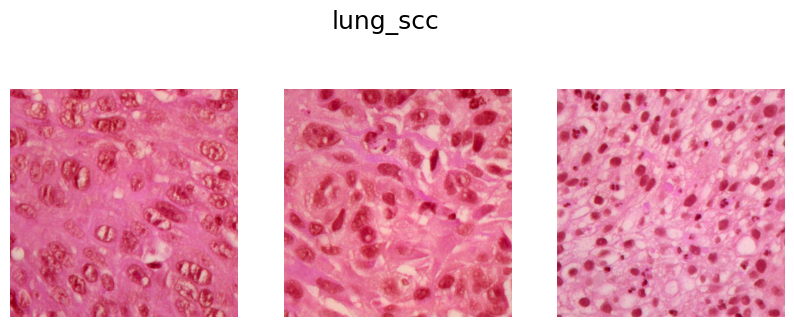

In [ ]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)

    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            img_array = cv2.imread(img_path)
            if img_array is not None:
                ax[i].imshow(img_array)
                ax[i].axis('off')
            else:
                print(f"Warning: Could not read image file: {img_path}")
        else:
            print(f"Skipping non-image file: {img_path}")


Omite archivos que no son imágenes.

Este fragmento de código tiene como objetivo visualizar ejemplos de imágenes de cada categoría en el conjunto de datos. Itera sobre cada categoría definida en CATEGORIES. Para cada categoría, construye la ruta a su directorio y lista todos los archivos que contiene. Luego, crea una figura con tres subtramas (espacios para mostrar imágenes) y le asigna un título con el nombre de la categoría. Dentro de un bucle, selecciona aleatoriamente tres nombres de archivo de imagen de la lista, construye la ruta completa a cada archivo y verifica si la extensión del archivo corresponde a un formato de imagen común. Si es una imagen, la lee usando OpenCV (cv2.imread), la muestra en una de las subtramas y desactiva los ejes para una visualización más limpia. Si no se puede leer la imagen o el archivo no es una imagen reconocida, se imprime una advertencia o un mensaje. Finalmente, después de procesar todas las categorías, se llama a plt.show() para mostrar todas las figuras con las imágenes seleccionadas.

# 6. definicion de clase Dataset y las transformaciones

In [ ]:
class LungCancerDataset(Dataset):

    def __init__(self, root_dir, categories, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for idx, category in enumerate(categories):
            folder = os.path.join(root_dir, category)
            for file in os.listdir(folder):
                self.data.append(os.path.join(folder, file))
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.ToTensor(),
])

# Explicación:

Esta sección de código, que abarca la definición de la clase LungCancerDataset y la secuencia de transformaciones, realiza las siguientes acciones paso a paso:

**1.  Define la clase LungCancerDataset:**

 * Declara una nueva clase llamada LungCancerDataset que hereda de torch.utils.data.Dataset. Esta herencia es fundamental para que PyTorch pueda usar esta clase con sus DataLoaders.
 * Método __init__ (Inicialización):
  * Se llama cuando creas un objeto LungCancerDataset.
  * Inicializa dos listas vacías: self.data (para almacenar las rutas completas de los archivos de imagen) y self.labels (para almacenar las etiquetas numéricas correspondientes).
  * Guarda la función de transformación (transform) proporcionada en self.transform.
  * Itera sobre cada category en la lista categories que se le pasa (por ejemplo, 'lung_aca', 'lung_n', 'lung_scc'). El enumerate también obtiene el idx (índice) de cada categoría, que se usará como etiqueta numérica.
  * Para cada categoría, construye la ruta completa a su carpeta (folder) uniendo root_dir y el nombre de la categoría.
  * Lista todos los archivos dentro de esa carpeta (os.listdir(folder)).
  * Itera sobre cada file encontrado en la carpeta.
  * Construye la ruta completa al archivo de imagen (os.path.join(folder, file)) y la añade a la lista self.data.
  * Añade el idx (índice numérico de la categoría) a la lista self.labels. De esta manera, cada imagen queda asociada a una etiqueta numérica que representa su clase.

* Método __len__ (Longitud):
 * Este método es requerido por Dataset.
 * Devuelve el número total de elementos en el dataset, que es simplemente la longitud de la lista self.data (el número total de imágenes encontradas).

* Método __getitem__ (Obtener elemento):
 * Este método es requerido por Dataset y se llama cuando un DataLoader solicita una muestra por su idx (índice).
 * Obtiene la ruta del archivo de imagen en el idx especificado de self.data.
 * Obtiene la etiqueta numérica correspondiente en el mismo idx de self.labels.
 * Abre la imagen usando PIL.Image.open(img_path) y la convierte al formato "RGB" para asegurar que tenga 3 canales de color, incluso si la imagen original es en escala de grises o tiene un canal alfa.
 * Verifica si se proporcionó una función de transform.
 * Si hay una transformación, aplica esa función a la imagen (image = self.transform(image)).
 * Devuelve la imagen procesada (después de aplicar las transformaciones, si las hay) y su etiqueta numérica.

**2. Define la secuencia de transformaciones (transform):**

* **Utiliza torchvision.transforms.Compose** para crear una lista secuencial de transformaciones que se aplicarán en orden.
* **transforms.Resize((IMG_SIZE, IMG_SIZE))**: Redimensiona la imagen a las dimensiones especificadas por IMG_SIZE (que previamente se definió como 224x224). Esto es necesario porque las redes neuronales suelen requerir imágenes de un tamaño fijo.
* transforms.RandomHorizontalFlip(): Aplica una inversión horizontal aleatoria a la imagen con una probabilidad del 50%. Esta es una técnica de aumento de datos para hacer que el modelo sea más robusto a la orientación de los objetos.
* **transforms.RandomRotation(15)**: Rota la imagen aleatoriamente dentro de un rango de -15 a +15 grados. Otra técnica de aumento de datos para manejar variaciones en la rotación.
* **transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0))**: Recorta aleatoriamente una parte de la imagen original (el área del recorte estará entre el 85% y el 100% del área original) y luego redimensiona este recorte al tamaño IMG_SIZE. Esto ayuda al modelo a ser menos sensible a la posición y escala de los objetos en la imagen.
* **transforms.ToTensor()**: Convierte la imagen, que probablemente es un objeto PIL en este punto, a un tensor de PyTorch. También escala automáticamente los valores de píxel al rango [0, 1] y reorganiza las dimensiones del tensor para que cumpla con el formato (Canales, Alto, Ancho), que es el formato esperado por los modelos de PyTorch.

# 7. Lista el contenido del directorio especificado

In [ ]:

!ls /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/

lung_aca  lung_n  lung_scc


# Explicación:

Este fragmento de código ejecuta un comando de shell dentro del entorno de Colab. El comando ls se utiliza en sistemas basados en Unix (como el que subyace a Colab) para listar el contenido de un directorio. En este caso, el directorio especificado es /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/. Al ejecutar esta celda, verás en la salida los nombres de los directorios y archivos que se encuentran directamente dentro de esa ruta. Esto se utiliza típicamente para verificar que el conjunto de datos se descargó correctamente y para confirmar los nombres exactos de las carpetas que contienen las imágenes de las diferentes categorías de cáncer de pulmón (lung_aca, lung_n, lung_scc), lo cual es crucial para la siguiente etapa donde se construye el Dataset.

# 8. Preparación final y división de los datos

In [ ]:
# Crea una instancia de la clase LungCancerDataset
dataset = LungCancerDataset(DATADIR, CATEGORIES, transform=transform)

# Calcula el tamaño del conjunto de entrenamiento (80%)
train_size = int(0.8 * len(dataset))

# Calcula el tamaño del conjunto de prueba (20%)
test_size = len(dataset) - train_size

# Divide el dataset original en entrenamiento y prueba
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crea un DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Crea un DataLoader para el conjunto de prueba
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Explicación:

Este bloque de código se encarga de la preparación final y división de los datos en conjuntos de entrenamiento y prueba, y luego crea objetos DataLoader para gestionarlos eficientemente durante el entrenamiento y la evaluación. Aquí está el desglose paso a paso:

1. Crea una instancia del Dataset:

dataset = LungCancerDataset(DATADIR, CATEGORIES, transform=transform): Se crea un objeto dataset de la clase LungCancerDataset que definiste anteriormente. Se le pasan el directorio raíz donde están las imágenes (DATADIR), la lista de nombres de las categorías (CATEGORIES) y la secuencia de transformaciones (transform) que se aplicarán a cada imagen que se cargue. En este paso, el objeto dataset internamente escanea los directorios y almacena las rutas de todas las imágenes y sus etiquetas correspondientes.

2. Calcula los tamaños de los conjuntos de entrenamiento y prueba:

train_size = int(0.8 * len(dataset)): Calcula cuántas imágenes corresponden al 80% del total del dataset. len(dataset) devuelve el número total de imágenes que encontró el LungCancerDataset. El resultado se convierte a entero (int) porque el número de muestras debe ser un número entero.

test_size = len(dataset) - train_size: Calcula el número restante de imágenes, que será el 20% restante, para el conjunto de prueba.

3. Divide el Dataset:

train_dataset, test_dataset = random_split(dataset, [train_size, test_size]): Utiliza la función random_split de PyTorch para dividir el objeto dataset original en dos subconjuntos: train_dataset y test_dataset. La división se realiza aleatoriamente, asegurando que no haya sesgos en la distribución de las clases (si el dataset original está bien mezclado) y que cada imagen vaya a un solo conjunto. Los tamaños de los subconjuntos se especifican en la lista [train_size, test_size].

4.-Crea DataLoaders:

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True): Crea un objeto DataLoader para el conjunto de entrenamiento (train_dataset). El DataLoader es responsable de iterar sobre el dataset en mini-lotes.

  * batch_size=BATCH_SIZE: Especifica el número de imágenes que habrá en cada mini-lote.

  * shuffle=True: Indica que los datos se deben mezclar aleatoriamente al comienzo de cada "época" de entrenamiento. Esto ayuda a prevenir que el modelo aprenda patrones basados en el orden de los datos.

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE): Crea un objeto DataLoader para el conjunto de prueba (test_dataset).

* batch_size=BATCH_SIZE: También usa el tamaño de lote para la evaluación.

* shuffle=False: No se necesita mezclar los datos durante la evaluación, ya que el orden no afecta el cálculo de las métricas

# 10. Configuraracion del modelo resnet50 para el entrenamiento utilizando la técnica de Transfer Learning

In [ ]:
# Configura el dispositivo (GPU o CPU) para ejecutar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carga el modelo ResNet50 pre-entrenado en ImageNet (Inicio del Transfer Learning)
d_cancerv1 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Congela las capas base del modelo pre-entrenado
for param in d_cancerv1.parameters():
    param.requires_grad = False

# Reemplaza la capa clasificadora final para adaptarse a 3 clases
d_cancerv1.fc = nn.Sequential(
    nn.Linear(d_cancerv1.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)

# Mueve el modelo al dispositivo configurado
d_cancerv1 = d_cancerv1.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


# Explicacion:

Este bloque de código se encarga de configurar el modelo para el entrenamiento utilizando la técnica de Transfer Learning. Aquí está la explicación paso a paso:


1. Configuración del Dispositivo:

 * device = torch.device("cuda" if torch.cuda.is_available() else "cpu"): Esta línea verifica si hay una GPU disponible en el sistema (PyTorch lo reconoce como "cuda"). Si es así, establece el dispositivo de trabajo en "cuda" para aprovechar la aceleración de la GPU; de lo contrario, utiliza la CPU ("cpu"). Esto es importante porque tanto el modelo como los datos deben estar en el mismo dispositivo para realizar cálculos.

2. Carga del Modelo Pre-entrenado (Inicio del Transfer Learning):

 * d_cancerv1 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT): Aquí es donde comienza el Transfer Learning. Se carga una versión de la arquitectura ResNet50 proporcionada por torchvision.models. Lo crucial es que se le indica que cargue los pesos (weights=models.ResNet50_Weights.DEFAULT) que ya han sido aprendidos entrenando este modelo en el gran conjunto de datos ImageNet. Esto le da al modelo una capacidad inicial para reconocer características visuales generales sin necesidad de empezar desde cero.

3. Congelación de las Capas Base:

 * for param in d_cancerv1.parameters(): param.requires_grad = False: Este bucle itera a través de todos los parámetros (pesos y sesgos) del modelo d_cancerv1 que acabas de cargar. Al establecer param.requires_grad = False para cada parámetro, estás "congelando" esas capas. Esto significa que durante la fase inicial del entrenamiento, los gradientes no se calcularán para estos parámetros, y sus valores no se actualizarán. La idea es preservar el conocimiento útil que el modelo ya aprendió de ImageNet en las capas convolucionales más bajas (que detectan características genéricas como bordes y texturas).

4. Reemplazo de la Capa Clasificadora Final:

 * d_cancerv1.fc = nn.Sequential(...): El modelo ResNet50 original tiene una capa final completamente conectada (fc) diseñada para clasificar imágenes en las 1000 categorías de ImageNet. Para adaptar el modelo a tu tarea específica de clasificar imágenes en 3 clases de cáncer de pulmón (NUM_CLASSES), esta capa final es reemplazada por una nueva secuencia de capas:

    * nn.Linear(d_cancerv1.fc.in_features, 512): Una capa lineal que toma la salida de la última capa convolucional (el tamaño de entrada es d_cancerv1.fc.in_features, que es el número de características antes de la capa fc original) y la mapea a 512 características.

    * nn.ReLU(): Una función de activación no lineal (Rectified Linear Unit) para introducir no linealidad en la red.
    * nn.Dropout(0.5): Una capa de Dropout que desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento. Esto ayuda a prevenir el sobreajuste al hacer que el modelo sea menos dependiente de cualquier neurona individual.
    * nn.Linear(512, NUM_CLASSES): Otra capa lineal que toma las 512 características de la capa anterior y las mapea al número de clases que necesitas predecir (NUM_CLASSES, que es 3 en este caso). Esta es la capa de salida final.
 * Esta nueva secuencia de capas es la parte del modelo que se entrenará desde cero en tu conjunto de datos.

5. Mover el Modelo al Dispositivo:

* d_cancerv1 = d_cancerv1.to(device): Finalmente, esta línea mueve todo el modelo (la arquitectura y los parámetros, incluyendo los pre-entrenados y los de la nueva capa final) al dispositivo especificado (device, ya sea GPU o CPU). Esto es esencial para que las operaciones de entrenamiento y evaluación se realicen en el hardware correcto.

# 11. Configuración y Entrenamiento Inicial (Solo Capa Clasificadora)

In [ ]:
# Define la función de pérdida (CrossEntropyLoss para clasificación multiclase)
criterion = nn.CrossEntropyLoss()

# Define el optimizador (Adam) para actualizar SÓLO los parámetros de la capa final (fc)
optimizer = optim.Adam(d_cancerv1.fc.parameters(), lr=0.001)

# Imprime un mensaje indicando el inicio del entrenamiento inicial
print("Entrenamiento inicial-solo cabeza")

# Bucle de entrenamiento (3 épocas)
for epoch in range(3):
    # Establece el modelo en modo de entrenamiento
    d_cancerv1.train()
    total_loss = 0
    # Itera sobre los lotes del DataLoader de entrenamiento
    for images, labels in train_loader:
        # Mueve los datos al dispositivo (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Limpia los gradientes acumulados
        optimizer.zero_grad()

        # Realiza la pasada hacia adelante
        outputs = d_cancerv1(images)

        # Calcula la pérdida
        loss = criterion(outputs, labels)

        # Realiza la retropropagación (calcula gradientes)
        loss.backward()

        # Actualiza los pesos (solo de la capa fc)
        optimizer.step()

        # Acumula la pérdida del lote
        total_loss += loss.item()

    # Imprime la pérdida promedio de la época
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Entrenamiento inicial-solo cabeza
Epoch 1 - Loss: 0.2144
Epoch 2 - Loss: 0.1378
Epoch 3 - Loss: 0.1281


# Explicación:

Este bloque de código lleva a cabo la fase de entrenamiento inicial del modelo, centrándose únicamente en la capa clasificadora (el "head" o fc) que se agregó. Aquí está la explicación paso a paso:

1. Define la función de pérdida:

criterion = nn.CrossEntropyLoss(): Se define la función de pérdida. CrossEntropyLoss es una función de pérdida estándar y muy utilizada para problemas de clasificación multiclase. Cuantifica la diferencia entre las probabilidades de clase predichas por el modelo y las etiquetas reales. El objetivo del entrenamiento es minimizar esta pérdida.

2. Define el optimizador:

optimizer = optim.Adam(d_cancerv1.fc.parameters(), lr=0.001): Se define el optimizador. optim.Adam es un algoritmo de optimización popular que ajusta los pesos del modelo basándose en los gradientes calculados. Lo crucial aquí es que d_cancerv1.fc.parameters() le dice al optimizador que solo debe actualizar los parámetros (pesos y sesgos) de la capa final (fc). Como las capas base del ResNet50 están congeladas (sus requires_grad es False), el optimizador las ignora. lr=0.001 establece la tasa de aprendizaje inicial, que determina el tamaño de los pasos que el optimizador toma para ajustar los pesos.

3. Mensaje de Inicio:

print("Entrenamiento inicial-solo cabeza"): Simplemente imprime un mensaje para indicar que esta fase de entrenamiento ha comenzado.

4. Bucle de Entrenamiento (Épocas):

for epoch in range(3):: Este bucle principal controla el número de "épocas" de entrenamiento. Una época es una pasada completa a través de todo el conjunto de datos de entrenamiento. En este caso, se entrena durante 3 épocas.

5. Modo de Entrenamiento:

d_cancerv1.train(): Dentro de cada época, esta línea pone el modelo en modo de entrenamiento. Esto es importante porque activa ciertas funcionalidades de capas como Dropout (si las hay) y configura las capas de Batch Normalization para calcular y usar estadísticas de lote durante la pasada hacia adelante y actualizar sus estadísticas acumuladas.

6. Inicializa la Pérdida Total de la Época:

total_loss = 0: Inicializa una variable para acumular la suma de las pérdidas calculadas en cada mini-lote dentro de la época actual.

7. Bucle de Mini-Lotes:

for images, labels in train_loader:: Este bucle itera sobre los mini-lotes proporcionados por el train_loader. En cada iteración, se obtienen un lote de images y sus labels correspondientes.

8. Mover Datos al Dispositivo:

images, labels = images.to(device), labels.to(device): Mueve las imágenes y las etiquetas del mini-lote al mismo dispositivo (device, GPU o CPU) donde se encuentra el modelo. Esto es necesario para realizar cálculos.

9. Limpiar Gradientes:

optimizer.zero_grad(): Antes de calcular los gradientes para el mini-lote actual, es crucial poner a cero los gradientes acumulados de las iteraciones anteriores. Esto evita que los gradientes de diferentes mini-lotes se sumen incorrectamente.

10. Pasada hacia Adelante (Forward Pass):

outputs = d_cancerv1(images): Las imágenes del mini-lote se pasan a través del modelo d_cancerv1. El modelo procesa las imágenes y produce las outputs, que son las puntuaciones (logits) para cada una de las 3 clases.

11. Calcular la Pérdida:

loss = criterion(outputs, labels): Se calcula la pérdida utilizando la función de pérdida (criterion) definida previamente. Se compara la salida del modelo (outputs) con las etiquetas reales (labels) del mini-lote.

12. Retropropagación (Backward Pass):

loss.backward(): Esta es la magia del aprendizaje profundo. Se calcula el gradiente de la función de pérdida con respecto a los parámetros entrenables del modelo (en esta fase, solo los de la capa fc). PyTorch calcula estos gradientes automáticamente.

13. Actualizar Pesos:

optimizer.step(): El optimizador (optimizer) utiliza los gradientes calculados en el paso anterior para actualizar los pesos de los parámetros que está optimizando (nuevamente, solo los de la capa fc) de una manera que reduce la pérdida.

14. Acumular Pérdida del Lote:

total_loss += loss.item(): La pérdida calculada para el mini-lote actual se suma a total_loss para llevar un registro de la pérdida total en la época. .item() extrae el valor numérico del tensor de pérdida.

15. Imprimir Pérdida Promedio de la Época:

print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}"): Al final de cada época, se imprime el número de la época y la pérdida promedio por mini-lote para esa época (total_loss dividido por el número de mini-lotes). Esto ayuda a monitorear el progreso del entrenamiento y ver si la pérdida está disminuyendo.

# 12. Implementa la fase de "Fine-Tuning" del modelo

In [ ]:
# 12. Implementa la fase de "Fine-Tuning" del modelo

# Descongela las últimas capas convolucionales ("layer4") y la capa final ("fc")
for name, param in d_cancerv1.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# Configura un nuevo optimizador con una tasa de aprendizaje baja para Fine-Tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, d_cancerv1.parameters()), lr=1e-5)

# Imprime un mensaje para indicar el inicio de la fase de Fine-Tuning.
print("Entrenamiento Fine-Tuning (últimas capas)")

# Inicia el bucle de entrenamiento para la fase de Fine-Tuning (en este caso, 5 épocas).
for epoch in range(5):
    d_cancerv1.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = d_cancerv1(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

Entrenamiento Fine-Tuning (últimas capas)
Epoch 1 - Loss: 0.0887
Epoch 2 - Loss: 0.0754
Epoch 3 - Loss: 0.0645
Epoch 4 - Loss: 0.0524
Epoch 5 - Loss: 0.0485


# Explicación:

1. Descongelación de Capas Específicas:

for name, param in d_cancerv1.named_parameters():: Este bucle itera sobre todos los parámetros del modelo d_cancerv1, obteniendo tanto el name (nombre único de la capa o parámetro) como el param (el tensor que contiene los pesos o sesgos).

if "layer4" in name or "fc" in name:: Dentro del bucle, esta condición verifica si el nombre del parámetro contiene la subcadena "layer4" o "fc".

* "layer4": Se refiere a una de las últimas etapas o grupos de capas convolucionales dentro de la arquitectura ResNet50. Estas capas aprenden características de nivel superior y son más específicas de las imágenes en las que se entrenó el modelo original (ImageNet). Al descongelarlas, permites que se ajusten a las características ligeramente diferentes que son relevantes para las imágenes de cáncer de pulmón.

* "fc": Se refiere a la capa completamente conectada (el clasificador) que reemplazaste y entrenaste en la fase anterior. Esta capa también se incluye para seguir ajustándose a medida que las capas convolucionales subyacentes cambian.

param.requires_grad = True: Si el nombre del parámetro coincide con la condición ("layer4" o "fc"), se establece su atributo requires_grad en True. ¿Por qué lo hace? Esto es lo opuesto a la congelación inicial. Al establecer requires_grad en True, le dices a PyTorch que calcule los gradientes para estos parámetros durante la retropropagación. Esto permite que sus pesos se actualicen a través del proceso de optimización. En esencia, estás "descongelando" estas capas para permitirles aprender a partir de tu conjunto de datos específico.

2. Configuración de un Nuevo Optimizador para Fine-Tuning:

optimizer = optim.Adam(filter(lambda p: p.requires_grad, d_cancerv1.parameters()), lr=1e-5): Se crea un nuevo objeto optimizador. Aunque podrías intentar reutilizar el anterior (con precauciones), crear uno nuevo con una configuración específica para el Fine-Tuning es común.

* optim.Adam(...): Se sigue utilizando el optimizador Adam, que es robusto y eficiente.

* filter(lambda p: p.requires_grad, d_cancerv1.parameters()): Esto es importante. En lugar de pasar todos los parámetros del modelo (d_cancerv1.parameters()), utilizas un filtro. El filtro (filter(...)) junto con una función lambda (lambda p: p.requires_grad) selecciona solamente los parámetros cuyo requires_grad es True. ¿Por qué lo hace? Esto asegura que el optimizador solo intente actualizar los pesos de las capas que has descongelado (layer4 y fc), dejando las capas convolucionales más tempranas (que aún tienen requires_grad = False) intactas.

* lr=1e-5: Se establece la tasa de aprendizaje (lr) en un valor significativamente más bajo que en la fase de entrenamiento inicial (0.001 vs 0.00001). ¿Por qué lo hace? Las capas pre-entrenadas (incluso las que estás ajustando finamente) ya tienen pesos razonables que capturan características importantes. Una tasa de aprendizaje baja permite que el optimizador realice ajustes muy pequeños y sutiles a estos pesos. Esto ayuda a "afinar" las características aprendidas a los detalles específicos de tu dataset sin el riesgo de "romper" o "olvidar" el conocimiento pre-entrenado valioso (lo que podría ocurrir con una tasa de aprendizaje alta).

3. Mensaje de Inicio de Fine-Tuning:

print("Entrenamiento Fine-Tuning (últimas capas)"): Un mensaje simple para indicar que la fase de ajuste fino ha comenzado.

4. Bucle de Entrenamiento (Fine-Tuning):

for epoch in range(5):: Se inicia el bucle de entrenamiento, esta vez para 5 épocas. La duración del Fine-Tuning suele ser menor que el entrenamiento inicial porque solo se están ajustando un subconjunto de capas y con una tasa de aprendizaje menor.

d_cancerv1.train(): Pone el modelo en modo de entrenamiento al comienzo de cada época, como antes.


total_loss = 0: Inicializa la pérdida total de la época.

for images, labels in train_loader:: Itera sobre los mini-lotes del train_loader.

images, labels = images.to(device), labels.to(device): Mueve los datos al dispositivo.

optimizer.zero_grad(): Limpia los gradientes acumulados del optimizador. Esto es esencial antes de calcular los gradientes para el lote actual.

outputs = d_cancerv1(images): Realiza la pasada hacia adelante, obteniendo las predicciones.

loss = criterion(outputs, labels): Calcula la pérdida utilizando el criterio de pérdida definido previamente (CrossEntropyLoss).

loss.backward(): Realiza la retropropagación, calculando los gradientes de la pérdida con respecto a los parámetros entrenables (los que tienen requires_grad=True). ¿Por qué lo hace? Este es el núcleo del aprendizaje; calcula cómo cada parámetro entrenable contribuyó al error.

optimizer.step(): Actualiza los pesos de los parámetros entrenables utilizando los gradientes calculados y la tasa de aprendizaje del optimizador. ¿Por qué lo hace? Este paso ajusta los pesos de layer4 y fc para reducir la pérdida.

total_loss += loss.item(): Acumula la pérdida del lote.

print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}"): Imprime la pérdida promedio de la época para monitorear el progreso.

# 13. Evaluación final

In [ ]:
# Establece el modelo en modo de evaluación
d_cancerv1.eval()

# Inicializa listas para almacenar predicciones y etiquetas reales
all_preds = []
all_labels = []

# Desactiva el cálculo de gradientes
with torch.no_grad():
    # Itera sobre los lotes del DataLoader de prueba
    for images, labels in test_loader:
        # Mueve las imágenes al dispositivo (GPU/CPU)
        images = images.to(device)

        # Realiza la pasada hacia adelante (inferencia)
        outputs = d_cancerv1(images)

        # Obtiene la clase predicha
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Acumula predicciones y etiquetas
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Explicación:

Este bloque de código se dedica a evaluar el rendimiento del modelo entrenado en el conjunto de datos de prueba. Inicia poniendo el modelo en modo de evaluación (d_cancerv1.eval()), lo cual desactiva capas y funcionalidades específicas del entrenamiento como Dropout. Luego, crea listas vacías para almacenar todas las predicciones del modelo (all_preds) y las etiquetas reales (all_labels) del conjunto de prueba. La evaluación se realiza dentro de un contexto with torch.no_grad(), que desactiva el cálculo de gradientes, ahorrando memoria y tiempo de computación, ya que la retropropagación no es necesaria durante la inferencia. El código itera a través del test_loader para obtener mini-lotes de imágenes y etiquetas. Cada lote de imágenes se mueve al dispositivo configurado, se pasa por el modelo para obtener las salidas (puntuaciones de clase), y se obtiene la predicción final seleccionando el índice con la puntuación más alta (torch.argmax). Las predicciones (movidas a la CPU y convertidas a NumPy) y las etiquetas reales (convertidas a NumPy) se añaden a sus respectivas listas. Al final de este bloque, las listas all_preds y all_labels contendrán las predicciones del modelo y las etiquetas reales para todas las imágenes en el conjunto de prueba, listas para calcular métricas de evaluación

# 14. Reporte y matriz de confusión


Clasificación final:
              precision    recall  f1-score   support

    lung_aca       0.99      0.99      0.99      1035
      lung_n       1.00      1.00      1.00       961
    lung_scc       0.99      0.99      0.99      1004

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



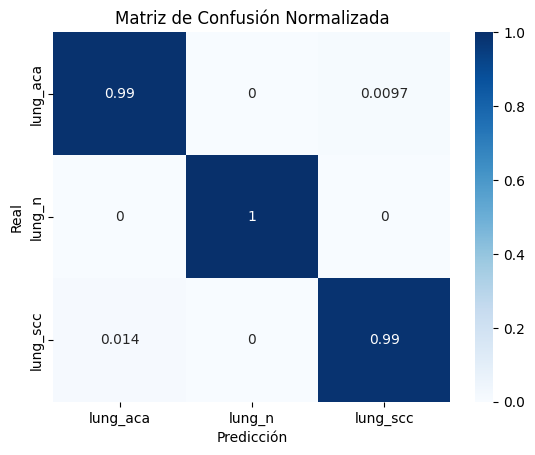

In [ ]:
# Imprime un encabezado para la sección de resultados de la clasificación final.
print("\nClasificación final:")

# Imprime un reporte de clasificación detallado.
print(classification_report(all_labels, all_preds, target_names=CATEGORIES))

# Calcula la matriz de confusión (normalizada por fila).
cf = confusion_matrix(all_labels, all_preds, normalize='true')

# Crea y muestra un heatmap de la matriz de confusión normalizada.
sns.heatmap(cf, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada")
plt.show()

# Explicación:

Este bloque de código tiene como objetivo presentar las métricas de evaluación del modelo de clasificación después de que se ha evaluado en el conjunto de prueba y se han recolectado todas las predicciones y etiquetas reales en las listas all_preds y all_labels. Primero, imprime un reporte de clasificación detallado utilizando classification_report. Este reporte muestra métricas clave como la precisión, el recall, el f1-score y el soporte para cada una de las clases (lung_aca, lung_n, lung_scc), proporcionando una visión completa del rendimiento del modelo por clase. Luego, calcula la matriz de confusión utilizando confusion_matrix. Esta matriz tabulariza el número (o proporción) de predicciones correctas e incorrectas para cada clase. Al normalizarla por fila (normalize='true'), muestra la proporción de veces que cada clase real fue predicha correctamente o incorrectamente como otra clase. Finalmente, utiliza la biblioteca seaborn para visualizar esta matriz de confusión normalizada como un mapa de calor (heatmap). La visualización incluye los valores numéricos en las celdas, las etiquetas de las clases en los ejes y un título, haciendo que sea fácil interpretar visualmente dónde el modelo está funcionando bien y dónde comete errores (confundiendo una clase con otra). La función plt.show() se llama para renderizar y mostrar este gráfico.

**Métricas del classification_report:**

El classification_report muestra métricas para cada clase individual (lung_aca, lung_n, lung_scc) y un resumen general.

**Precision (Precisión):**

¿Qué mide? La proporción de predicciones positivas (para una clase específica) que fueron realmente correctas. Es decir, de todas las veces que el modelo dijo que una imagen pertenecía a la clase X, ¿cuántas veces acertó?

Fórmula: Precision = Verdaderos Positivos / (Verdaderos Positivos + Falsos Positivos)

Interpretación: Una alta precisión para una clase significa que cuando el modelo predice esa clase, es muy probable que esté en lo cierto. Es importante cuando el costo de un falso positivo es alto.

**Recall (Exhaustividad o Sensibilidad):**

¿Qué mide? La proporción de instancias reales de una clase específica que fueron correctamente identificadas por el modelo. Es decir, de todas las imágenes que realmente pertenecen a la clase X, ¿cuántas logró detectar el modelo?
Fórmula: Recall = Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)

Interpretación: Un alto recall para una clase significa que el modelo es bueno para encontrar todas las instancias de esa clase. Es importante cuando el costo de un falso negativo es alto (por ejemplo, no detectar una enfermedad).

**F1-score (Puntuación F1):**

¿Qué mide? Es la media armónica de la precisión y el recall. Proporciona un balance entre ambas métricas.

Fórmula: F1-score = 2 * (Precision * Recall) / (Precision + Recall)

Interpretación: Un F1-score alto indica que el modelo tiene un buen balance entre precisión y recall para esa clase. Es útil cuando hay un desbalance de clases o cuando tanto los falsos positivos como los falsos negativos tienen costos similares.

**Support (Soporte):**

¿Qué mide? El número de instancias reales (muestras) de esa clase en el conjunto de prueba.

Interpretación: Te indica cuántos ejemplos había de cada clase en el conjunto de prueba, lo cual es útil para entender la distribución de las clases y contextualizar las otras métricas.

**Resumen General del classification_report:**

**accuracy (Exactitud): **La proporción general de predicciones correctas sobre el total de predicciones. Se calcula como (Verdaderos Positivos + Verdaderos Negativos) / Total de Muestras. Es una métrica simple pero puede ser engañosa en conjuntos de datos con clases desbalanceadas.

**macro avg (Promedio Macro):** Calcula la media no ponderada de la precisión, recall y F1-score para todas las clases. Trata a todas las clases por igual, independientemente de cuántas instancias tengan.

weighted avg (Promedio Ponderado): Calcula la media ponderada de la precisión, recall y F1-score para todas las clases, donde el peso es el "support" (número de instancias) de cada clase. Esto es útil cuando hay desbalance de clases, ya que le da más peso a las clases con más ejemplos.

Matriz de Confusión Normalizada:

La matriz de confusión es una tabla que muestra cuántas veces el modelo predijo correctamente (diagonal principal) e incorrectamente (fuera de la diagonal principal) cada clase.

Filas: Representan las clases reales.

Columnas: Representan las clases predichas.

Celda (i, j): Muestra el número o la proporción de instancias que realmente pertenecen a la clase i y fueron predichas como clase j.

Cuando la matriz está normalizada por fila (normalize='true'):

Cada valor en una fila representa la proporción de instancias de esa clase real que fueron clasificadas en cada clase predicha.
La suma de los valores en cada fila es 1.0.
La diagonal principal muestra el Recall (tasa de verdaderos positivos) para cada clase. Por ejemplo, la celda en la fila "lung_aca" y columna "lung_aca" muestra la proporción de imágenes de "lung_aca" que fueron correctamente predichas como "lung_aca".

**Interpretación de la Matriz Normalizada:**

Los valores altos en la diagonal principal (de arriba a la izquierda a abajo a la derecha) indican que el modelo predice correctamente las instancias de esas clases.

Los valores altos fuera de la diagonal principal indican que el modelo está confundiendo una clase real (fila) con una clase predicha (columna). Por ejemplo, un valor alto en la fila "lung_scc" y columna "lung_aca" significaría que el modelo confunde con frecuencia el carcinoma de células escamosas con el adenocarcinoma.

# 15. Guardar en checkpoint

In [ ]:
# Define una variable 'PATH' que especifica el nombre del archivo donde se guardará el checkpoint del modelo.
PATH = './checkpoint.pt'
# Guarda el estado interno del modelo (state_dict) en un archivo.
torch.save(d_cancerv1.state_dict(), PATH)

# Explicación:

Este breve fragmento de código se encarga de guardar los pesos y sesgos aprendidos del modelo entrenado. Primero, define una variable PATH que especifica la ruta y el nombre del archivo donde se almacenará la información del modelo, en este caso, un archivo llamado checkpoint.pt en el directorio actual. Luego, utiliza la función torch.save() para serializar y guardar el state_dict del modelo d_cancerv1 en ese archivo. El state_dict es un diccionario de Python que contiene el estado persistente del modelo, incluyendo todos los parámetros del modelo (como pesos y sesgos) y búferes no persistentes. Guardar solo el state_dict es una práctica común en PyTorch, ya que permite cargar los pesos en diferentes arquitecturas de modelo, lo cual es útil para la transfer learning o para modelos con modificaciones. En esencia, este código crea un "checkpoint" del modelo entrenado en el disco, permitiendo su posterior carga y reutilización sin necesidad de reentrenar.

# 16. Guardar en modelo

In [ ]:
# Guarda el modelo completo (incluyendo la arquitectura y los pesos) en un archivo.

torch.save(d_cancerv1, 'd_cancerv1.pt')

# Explicación:

Este fragmento de código guarda el modelo completo, incluyendo su arquitectura y todos sus parámetros aprendidos, en un archivo llamado d_cancerv1.pt. A diferencia del método anterior que solo guardaba el state_dict (los pesos y sesgos), esta función torch.save() serializa la instancia completa del objeto modelo. Esto significa que al cargar el modelo más tarde, no necesitarás tener la definición de la clase del modelo original disponible explícitamente, ya que está incluida en el archivo guardado. Si bien esto puede ser conveniente para guardar y cargar rápidamente el modelo, puede ser menos flexible si planeas usar los pesos en una arquitectura de modelo ligeramente modificada o si la estructura exacta de la clase original no está garantizada al cargar. Esencialmente, crea un "archivo de modelo" completo que contiene todo lo necesario para reconstruir y utilizar el modelo entrenado.

# 17. Cargar checkpoint

In [ ]:
# Carga el state_dict (los pesos y sesgos) guardado previamente desde el archivo especificado por PATH.

d_cancerv1.load_state_dict(torch.load(PATH))

# Establece el modelo en modo de evaluación.

d_cancerv1.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Explicación:

Este fragmento de código se utiliza para cargar un modelo entrenado previamente a partir de un archivo de checkpoint. La primera línea utiliza torch.load(PATH) para leer el state_dict (el diccionario que contiene los pesos y sesgos del modelo) desde el archivo especificado por la variable PATH (que apunta a 'checkpoint.pt'). Luego, d_cancerv1.load_state_dict() toma este state_dict cargado y lo aplica a la instancia actual del modelo d_cancerv1, actualizando así sus parámetros a los valores guardados. Esto efectivamente restaura el modelo a su estado en el momento en que se guardó el checkpoint. La segunda línea, d_cancerv1.eval(), es fundamental y pone el modelo en modo de evaluación. Esto deshabilita funcionalidades específicas del entrenamiento como Dropout y asegura que las capas como Batch Normalization utilicen estadísticas acumuladas en lugar de estadísticas de lote, lo cual es necesario para obtener resultados consistentes y fiables durante la inferencia o la evaluación en el conjunto de prueba. En conjunto, estas líneas permiten cargar un modelo entrenado y prepararlo para su uso en la predicción o la evaluación.

# 17. Evaluar el checkpoint cargado


Reporte de Clasificación para el checkpoint cargado:


acc 0.99069: 100%|██████████| 94/94 [00:33<00:00,  2.79it/s]

              precision    recall  f1-score   support

    lung_aca       0.99      0.98      0.99      1035
      lung_n       1.00      1.00      1.00       961
    lung_scc       0.98      0.99      0.99      1004

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



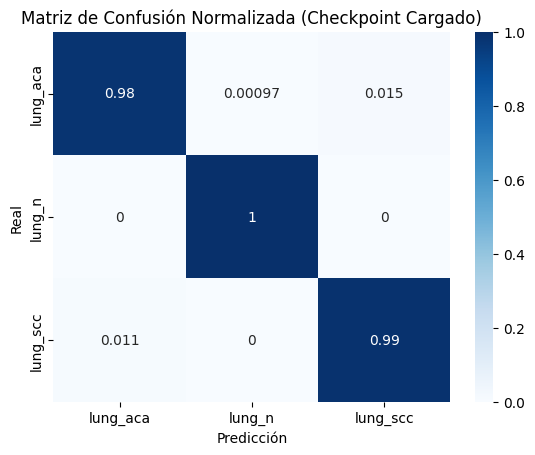

In [ ]:
# prompt: Evaluar las metricas para  cargado para d_cancerv1 de todas las categorias existentes

import matplotlib.pyplot as plt
# 17. Evaluar el checkpoint cargado
# Importa la biblioteca tqdm, que se utiliza para mostrar barras de progreso.
from tqdm import tqdm
import numpy as np # Asegura que numpy esté importado para np.mean
import torch # Asegura que torch esté importado

# Opcional: Calcular y mostrar el reporte de clasificación y la matriz de confusión
# Si deseas ver el reporte de clasificación y la matriz de confusión para el modelo cargado,
# puedes repetir el código del paso 14.
# Asegúrate de que all_labels y all_preds se recalculen si es necesario,
# o si la función evaluate ya los está recolectando, úsalos aquí.

print("\nReporte de Clasificación para el checkpoint cargado:")

# Para obtener el classification_report y la confusion_matrix,
# necesitas recolectar todas las predicciones y etiquetas nuevamente
# durante la evaluación. Modificamos la función evaluate para hacerlo.

def evaluate_and_collect_metrics(d_cancerv1, dataloader):
    d_cancerv1.eval()
    d_cancerv1.to(device)

    all_preds = []
    all_labels = []

    bar = tqdm(dataloader)
    acc = []

    with torch.no_grad():
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)

            y_hat = d_cancerv1(X)

            preds = torch.argmax(y_hat, dim=1).cpu().numpy()
            labels_np = y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels_np)

            acc.append((y == torch.argmax(y_hat, axis=1)).sum().item() / len(y))
            bar.set_description(f"acc {np.mean(acc):.5f}")

    return all_labels, all_preds

# Vuelve a evaluar el conjunto de prueba para recolectar las predicciones y etiquetas
all_labels_loaded, all_preds_loaded = evaluate_and_collect_metrics(d_cancerv1, test_loader)

# Imprime el reporte de clasificación detallado
print(classification_report(all_labels_loaded, all_preds_loaded, target_names=CATEGORIES))

# Calcula la matriz de confusión normalizada
cf_loaded = confusion_matrix(all_labels_loaded, all_preds_loaded, normalize='true')

# Crea y muestra el heatmap de la matriz de confusión
plt.figure() # Crea una nueva figura para el heatmap
sns.heatmap(cf_loaded, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada (Checkpoint Cargado)")
plt.show()



# 18 Definición de la Función de Bucle de Entrenamiento por Época

In [ ]:
import matplotlib.pyplot as plt  # Para crear las gráficas
import torch  # Biblioteca para computación con tensores y entrenamiento de modelos

# Función generalizada para entrenar el modelo durante un número de épocas
def train_model(model, loader, optimizer, criterion, device, epochs, phase):
    model.train()  # Establece el modelo en modo entrenamiento (activa dropout, batchnorm, etc.)
    losses, accuracies = [], []  # Listas para guardar pérdida y precisión por época

    print(f"\nEntrenamiento: {phase} ({epochs} épocas)")  # Mensaje indicando fase y número de épocas
    for epoch in range(1, epochs + 1):  # Bucle de entrenamiento por época
        total_loss, correct, total = 0, 0, 0  # Inicializa métricas acumulativas

        for images, labels in loader:  # Itera sobre los batches del DataLoader
            images, labels = images.to(device), labels.to(device)  # Mueve datos a GPU o CPU

            optimizer.zero_grad()  # Reinicia los gradientes del optimizador
            outputs = model(images)  # Hace predicción (forward pass)
            loss = criterion(outputs, labels)  # Calcula la pérdida (error) entre predicción y verdad
            loss.backward()  # Backpropagation: calcula gradientes
            optimizer.step()  # Actualiza los pesos del modelo con los gradientes

            total_loss += loss.item()  # Suma la pérdida del batch a la pérdida total
            _, preds = torch.max(outputs, 1)  # Obtiene las clases predichas con mayor probabilidad
            total += labels.size(0)  # Cuenta cuántos ejemplos se han procesado
            correct += (preds == labels).sum().item()  # Cuenta cuántas predicciones fueron correctas

        avg_loss = total_loss / len(loader)  # Calcula pérdida promedio por época
        accuracy = correct / total if total else 0  # Calcula precisión de la época
        losses.append(avg_loss)  # Guarda la pérdida promedio
        accuracies.append(accuracy)  # Guarda la precisión

        # Imprime resumen de la época
        print(f"Época {epoch}: Pérdida = {avg_loss:.4f}, Precisión = {accuracy:.4f}")

    return losses, accuracies  # Devuelve métricas de entrenamiento

# --- Entrenamiento Inicial (solo cabeza de red) ---
epochs_initial = 3  # Número de épocas para la fase inicial
train_losses, train_accuracies = train_model(
    d_cancerv1,  # Modelo a entrenar
    train_loader,  # DataLoader con los datos de entrenamiento
    optimizer,  # Optimizador configurado previamente
    criterion,  # Función de pérdida (por ejemplo, CrossEntropyLoss)
    device,  # CPU o GPU
    epochs_initial,  # Número de épocas
    phase="Inicial (solo cabeza)"  # Nombre de la fase para mostrar en consola
)

# --- Fine-Tuning (ajuste fino del modelo completo) ---
# Asegúrate de haber descongelado capas y ajustado el optimizador aquí antes
epochs_finetune = 5  # Número de épocas para fine-tuning
finetune_losses, finetune_accuracies = train_model(
    d_cancerv1,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs_finetune,
    phase="Fine-Tuning"
)


Entrenamiento: Inicial (solo cabeza) (3 épocas)
Época 1: Pérdida = 0.0398, Precisión = 0.9853
Época 2: Pérdida = 0.0379, Precisión = 0.9858
Época 3: Pérdida = 0.0323, Precisión = 0.9882

Entrenamiento: Fine-Tuning (5 épocas)
Época 1: Pérdida = 0.0307, Precisión = 0.9892
Época 2: Pérdida = 0.0255, Precisión = 0.9912
Época 3: Pérdida = 0.0243, Precisión = 0.9904
Época 4: Pérdida = 0.0238, Precisión = 0.9919
Época 5: Pérdida = 0.0187, Precisión = 0.9935


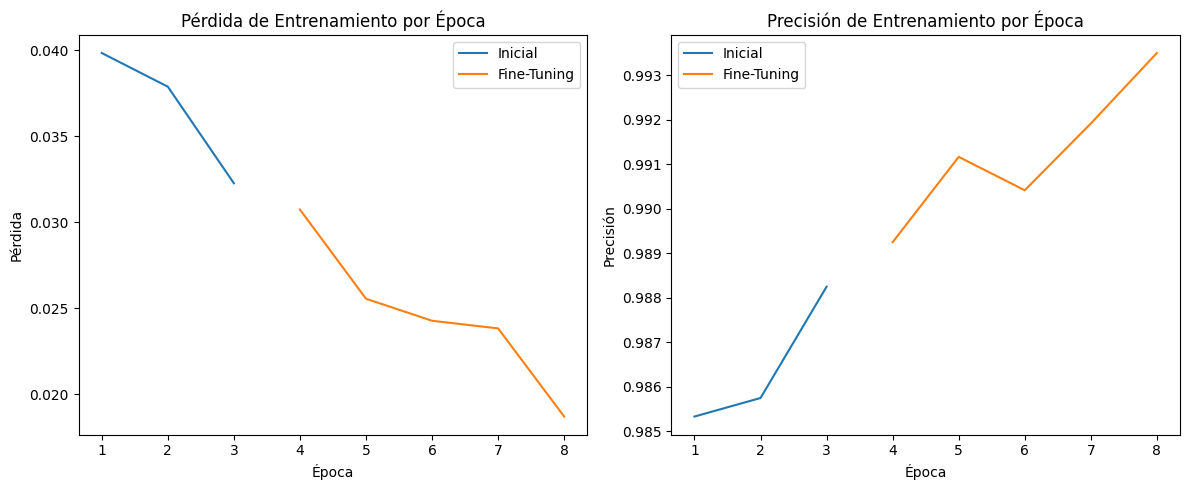

In [ ]:
# Graficar la pérdida y la precisión de entrenamiento por época (separado por fases)
plt.figure(figsize=(12, 5))

# Gráfica de Pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Inicial')
plt.plot(range(len(train_losses) + 1, len(train_losses) + len(finetune_losses) + 1), finetune_losses, label='Fine-Tuning')
plt.title('Pérdida de Entrenamiento por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de Precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Inicial')
plt.plot(range(len(train_accuracies) + 1, len(train_accuracies) + len(finetune_accuracies) + 1), finetune_accuracies, label='Fine-Tuning')
plt.title('Precisión de Entrenamiento por Época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


Reporte de Clasificación para el último modelo entrenado:
              precision    recall  f1-score   support

    lung_aca       0.99      0.98      0.99      1035
      lung_n       1.00      1.00      1.00       961
    lung_scc       0.98      0.99      0.99      1004

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



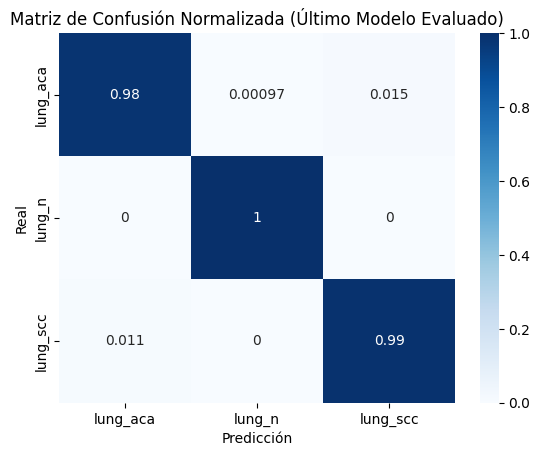

In [ ]:
# prompt: Reporte de las metricas de Clasificación, asi como la matriz de confusion del ultimo modelo enetrando en la seccion de codigo anteriro

import matplotlib.pyplot as plt
print("\nReporte de Clasificación para el último modelo entrenado:")

# Imprime el reporte de clasificación detallado (usa las variables del paso 13 o la re-evaluación si se hizo)
# Si no re-evaluaste, all_labels y all_preds del paso 13 contienen los resultados.
# Si usaste evaluate_and_collect_metrics más tarde, usa all_labels_loaded y all_preds_loaded.
# Asumiendo que quieres el reporte del modelo DESPUÉS del fine-tuning, usamos las variables del paso 13
# o si la función evaluate_and_collect_metrics se ejecutó después del fine-tuning, usaremos esas.
# Como el código proporcionado ejecuta la evaluación del checkpoint después del fine-tuning
# (aunque el checkpoint cargado podría no ser el *último* estado del fine-tuning a menos que lo guardaras),
# usaremos las variables de la última evaluación en el código dado, que son all_labels_loaded y all_preds_loaded.

print(classification_report(all_labels_loaded, all_preds_loaded, target_names=CATEGORIES))

# Calcula la matriz de confusión (normalizada por fila) para el último modelo evaluado
cf_loaded = confusion_matrix(all_labels_loaded, all_preds_loaded, normalize='true')

# Crea y muestra un heatmap de la matriz de confusión normalizada
plt.figure() # Crea una nueva figura para el heatmap
sns.heatmap(cf_loaded, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada (Último Modelo Evaluado)")
plt.show()


# Guardar la ultima version

In [ ]:
torch.save(d_cancerv1, 'd_cancerv2.pt')

Modelo cargado exitosamente para predicción.

--- Realizando Predicciones en Imágenes Aleatorias ---

Seleccionando imágenes aleatorias de la categoría: lung_aca
Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca3652.jpeg


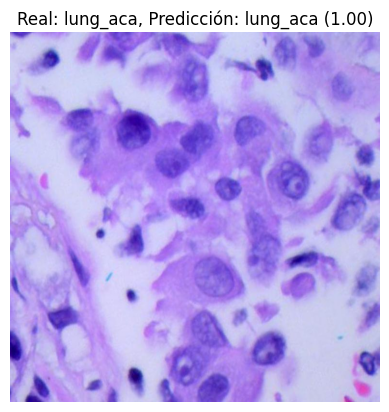

Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1593.jpeg


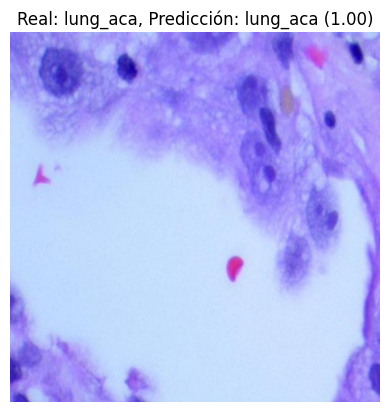

Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1425.jpeg


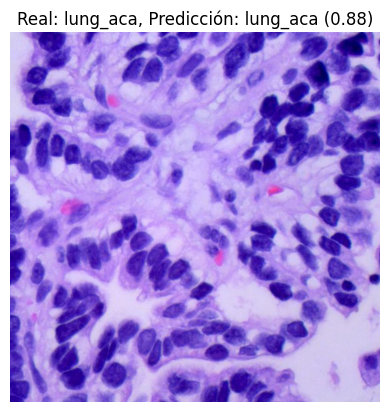


Seleccionando imágenes aleatorias de la categoría: lung_n
Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn2940.jpeg


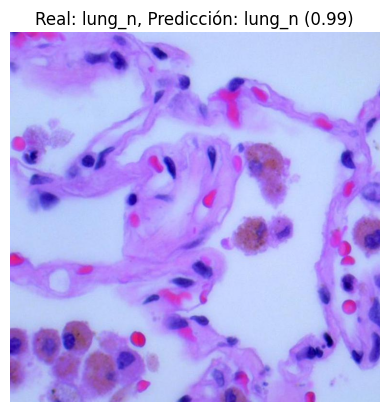

Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn4977.jpeg


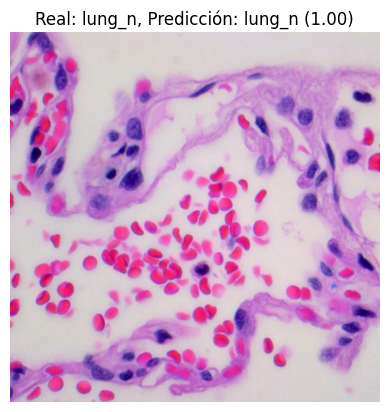

Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn866.jpeg


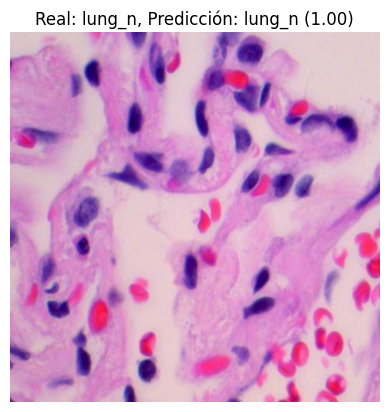


Seleccionando imágenes aleatorias de la categoría: lung_scc
Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc2823.jpeg


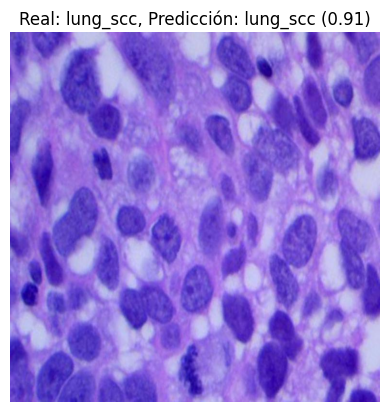

Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc2861.jpeg


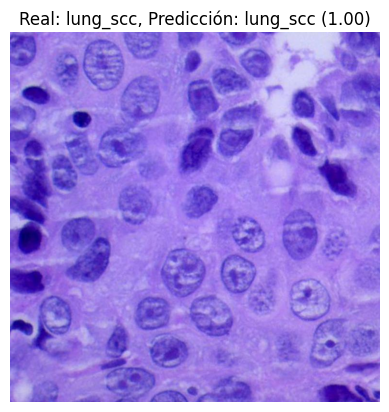

Prediciendo para: /content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc392.jpeg


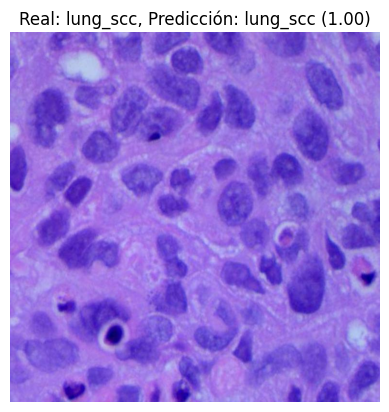


--- Resumen de Predicciones Aleatorias ---

Categoría Real: lung_aca
  Imagen: lungaca3652.jpeg
    Predicción: lung_aca
    Probabilidad: 0.9996
--------------------
  Imagen: lungaca1593.jpeg
    Predicción: lung_aca
    Probabilidad: 0.9967
--------------------
  Imagen: lungaca1425.jpeg
    Predicción: lung_aca
    Probabilidad: 0.8821
--------------------

Categoría Real: lung_n
  Imagen: lungn2940.jpeg
    Predicción: lung_n
    Probabilidad: 0.9881
--------------------
  Imagen: lungn4977.jpeg
    Predicción: lung_n
    Probabilidad: 1.0000
--------------------
  Imagen: lungn866.jpeg
    Predicción: lung_n
    Probabilidad: 0.9997
--------------------

Categoría Real: lung_scc
  Imagen: lungscc2823.jpeg
    Predicción: lung_scc
    Probabilidad: 0.9127
--------------------
  Imagen: lungscc2861.jpeg
    Predicción: lung_scc
    Probabilidad: 0.9994
--------------------
  Imagen: lungscc392.jpeg
    Predicción: lung_scc
    Probabilidad: 0.9999
--------------------


In [ ]:
# prompt: genera una seccion de codigo para predecir usando el modelo enetrado en la seccion anterior, debe usar las imagnes del as categoarias de manera aleaoria

import matplotlib.pyplot as plt
import random
from PIL import Image

# Cargar el modelo entrenado
# Asegúrate de que 'd_cancerv2.pt' es la ruta correcta al modelo guardado
# Si usaste 'checkpoint.pt' para guardar solo el state_dict, necesitarás cargar la arquitectura primero
try:
    # FIX: Set weights_only=False to load the full model object saved previously
    d_cancerv2 = torch.load('d_cancerv2.pt', weights_only=False)
    d_cancerv2.to(device) # Mueve el modelo al dispositivo
    d_cancerv2.eval()    # Pon el modelo en modo evaluación
    print("Modelo cargado exitosamente para predicción.")
except FileNotFoundError:
    print("Error: Archivo de modelo 'd_cancerv2.pt' no encontrado. Asegúrate de haber guardado el modelo.")
    # Si el modelo no se carga, salimos o manejamos el error adecuadamente.
    # Puedes agregar 'exit()' o 'raise' aquí si no quieres continuar sin el modelo.
    # Para este ejemplo, asumimos que el modelo d_cancerv1 del código anterior está disponible si la carga falla.
    # Asignamos d_cancerv1 para que el resto del código pueda ejecutarse,
    # aunque la predicción usará el modelo en memoria si la carga falla.
    d_cancerv2 = d_cancerv1
    print("Usando el modelo d_cancerv1 en memoria para predicción.")
except Exception as e:
    print(f"Error cargando el modelo: {e}")
    # Asignamos d_cancerv1 como fallback
    d_cancerv2 = d_cancerv1
    print("Usando el modelo d_cancerv1 en memoria debido a un error de carga.")


# Define las transformaciones para una única imagen para predicción
# Estas deben ser consistentes con las transformaciones de prueba/evaluación
# (normalmente solo Resize y ToTensor, sin aumento de datos)
predict_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Mapeo de índices predichos a nombres de categorías
# Asegúrate de que este mapeo coincide con el orden de CATEGORIES
idx_to_class = {i: class_name for i, class_name in enumerate(CATEGORIES)}

# Función para predecir la clase de una sola imagen
def predict_image(image_path, model, transform, device, idx_to_class):
    try:
        # Abre la imagen y conviértela a RGB
        image = Image.open(image_path).convert("RGB")

        # Aplica las transformaciones
        image = transform(image)

        # Añade una dimensión de lote (batch dimension)
        image = image.unsqueeze(0) # Añade una dimensión al inicio (batch size = 1)

        # Mueve la imagen al dispositivo
        image = image.to(device)

        # Realiza la predicción (inferencia)
        with torch.no_grad(): # Desactiva el cálculo de gradientes para la inferencia
            output = model(image)

        # Obtiene las probabilidades (opcional, pero útil)
        probabilities = torch.softmax(output, dim=1)

        # Obtiene el índice de la clase predicha
        predicted_index = torch.argmax(probabilities, dim=1).item()

        # Obtiene el nombre de la clase predicha
        predicted_class = idx_to_class[predicted_index]

        # Obtiene la probabilidad de la clase predicha
        predicted_prob = probabilities[0, predicted_index].item()

        return predicted_class, predicted_prob, predicted_index

    except FileNotFoundError:
        return f"Error: Archivo no encontrado en {image_path}", None, None
    except Exception as e:
        return f"Error procesando la imagen {image_path}: {e}", None, None

# --- Sección para predecir usando imágenes aleatorias de las categorías ---

print("\n--- Realizando Predicciones en Imágenes Aleatorias ---")

# Selecciona una imagen aleatoria de cada categoría para predecir
num_random_images_per_category = 3 # Número de imágenes aleatorias por categoría
predicted_results = {} # Diccionario para guardar los resultados

for category in CATEGORIES:
    print(f"\nSeleccionando imágenes aleatorias de la categoría: {category}")
    category_path = os.path.join(DATADIR, category)

    try:
        # Lista todos los archivos en el directorio de la categoría
        all_images_in_category = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]

        if not all_images_in_category:
            print(f"No se encontraron imágenes válidas en {category_path}")
            continue

        # Selecciona aleatoriamente un subconjunto de imágenes (sin repetición si hay suficientes)
        num_to_select = min(num_random_images_per_category, len(all_images_in_category))
        random_image_names = random.sample(all_images_in_category, num_to_select)

        predicted_results[category] = []

        # Realiza la predicción para cada imagen seleccionada
        for img_name in random_image_names:
            img_path = os.path.join(category_path, img_name)
            print(f"Prediciendo para: {img_path}")

            # Usamos d_cancerv2 que contiene el modelo cargado o el fallback d_cancerv1
            predicted_class, predicted_prob, _ = predict_image(img_path, d_cancerv2, predict_transform, device, idx_to_class)

            result = {
                "image": img_name,
                "path": img_path,
                "real_class": category,
                "predicted_class": predicted_class,
                "predicted_probability": predicted_prob
            }
            predicted_results[category].append(result)

            # Opcional: Muestra la imagen con la predicción
            if predicted_prob is not None:
                try:
                    img_display = Image.open(img_path)
                    plt.imshow(img_display)
                    plt.title(f"Real: {category}, Predicción: {predicted_class} ({predicted_prob:.2f})")
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"Error mostrando imagen {img_name}: {e}")


    except FileNotFoundError:
        print(f"Error: Directorio de categoría no encontrado en {category_path}")
    except Exception as e:
        print(f"Ocurrió un error al procesar la categoría {category}: {e}")

# --- Mostrar un resumen de las predicciones ---

print("\n--- Resumen de Predicciones Aleatorias ---")
for category, results in predicted_results.items():
    print(f"\nCategoría Real: {category}")
    if not results:
        print("  No se realizaron predicciones para esta categoría.")
        continue
    for result in results:
        print(f"  Imagen: {result['image']}")
        print(f"    Predicción: {result['predicted_class']}")
        print(f"    Probabilidad: {result['predicted_probability']:.4f}")
        print("-" * 20)